# Multi-Fidelity Bayesian Optimization Method for design-space exploration with noisy evaluations
Multi-Fidelity Bayesian Optimization (MFBO)

In [1]:
import os
import torch
import botorch # library for Bayesian Optimisation research
import gpytorch
torch.set_default_dtype(torch.double)

SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')

Running on PyTorch 1.12.1, Botorch 0.8.1, using cpu device


In [ ]:
print(f'Running on gpytorch {gpytorch.__version__}')
print(f'Running on numpy {np.__version__}')
import sklearn, scipy, matplotlib,pyDOE
print(f'Running on sklearn {sklearn.__version__}')
print(f'Running on scipy {scipy.__version__}')
print(f'Running on matplotlib {matplotlib.__version__}')
print(f'Running on pandas {pd.__version__}')
print(f'Running on pydoe {pyDOE.__version__}')

### Problem setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from MinMaxScaler import inverse_transform
data = 'data/Case3_finer.csv'
# Data loading
def load_data(data=data):
    df = pd.read_csv(data)
    X_data  = np.vstack([df["alpha0"].to_numpy() ,
                df["alpha1"].to_numpy() ,
                df["alpha2"].to_numpy() ,
                df["alpha3"].to_numpy() ])
    pts = X_data.T.copy()
    pts = StandardScaler().fit_transform(pts)
    '''COMPUTE DIFFERENT CASES AND PLOT THEM'''
    #Cx_data = df['SumCx'].to_numpy() 
    Cx_data = np.vstack([df['SumCx'].to_numpy() ,
                         df['SumCy'].to_numpy() ])

    #obs = Cx_data.reshape(-1,1).copy()
    obs = Cx_data.T.copy() 
    obs = StandardScaler().fit_transform(obs)
    return pts, obs

In [3]:
from sklearn.decomposition import PCA
   
# Compute PCA 
def PCA_transformation(pts_original):
    pca = PCA(n_components=4, svd_solver='full').fit(pts_original)
    pts_transformed = pca.transform(pts_original)
    return pts_transformed

In [4]:
from pyDOE import lhs
from scipy.interpolate import NearestNDInterpolator

# Sample RSMs
def data_resample(pts, obs):
    dim = pts.shape[1]
    N = 10000
    lb = np.min( pts,axis=0)
    ub = np.max( pts,axis=0)
    bounds = {'lb': lb, 'ub': ub}
    # Generate latin-hypercube
    new_pts = lb + (ub - lb) * lhs(dim, N) 
    # pts are not in convex hull of pts (LD interpolator does not extrapolate) 
    r =  NearestNDInterpolator( pts, obs)
    # pts has to be inside region of interpolation .
    valuesTrasf = r(new_pts) 
    #valuesTrasf.reshape(-1,1).T
    return new_pts,valuesTrasf

In [5]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

pts, obs = load_data()
pts = PCA_transformation(pts)
new_pts,new_obs = data_resample(pts, obs)

class TestcaseDataset(Dataset):
    def __init__(self,new_pts,new_obs,dim):
        data = np.hstack([new_pts,new_obs]) 
        hifi, lofi = train_test_split(data, test_size=1e-3, shuffle=True)
        hifi, test = train_test_split(hifi, test_size=1e-1)
        size=dim-data.shape[1]
        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:size]) 
        self.X_lofi = torch.Tensor(lofi[:,:size]) 
        self.X_test = torch.Tensor(test[:,:size]) 
        self.Y_hifi = torch.Tensor(hifi[:,size:])#.unsqueeze(-1)
        self.Y_lofi = torch.Tensor(lofi[:,size:])#.unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,size:])#.unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
    def __call__(self):
        return (self.hifi_dataset, 
                self.test_dataset, 
                self.X_hifi, 
                self.X_lofi, 
                self.X_test, 
                self.Y_hifi, 
                self.Y_lofi, 
                self.Y_test, 
                )

In [47]:
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import unnormalize, normalize
#bounds = torch.stack([-2.5 * torch.ones(pts.shape[-1]), 2.5 * torch.ones(pts.shape[-1])])
dataset = TestcaseDataset(new_pts,new_obs,pts.shape[1])

X_lofi = dataset.X_lofi#normalize(dataset.X_lofi,bounds=bounds)
X_hifi = dataset.X_hifi#normalize(dataset.X_hifi,bounds=bounds)
X_test = dataset.X_test#normalize(dataset.X_test,bounds=bounds)
Y_lofi = dataset.Y_lofi
Y_hifi = dataset.Y_hifi
Y_test = dataset.Y_test

hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset

print("Shape of low fidelity  X and y: ",X_lofi.shape, Y_lofi.shape)
print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
bounds = torch.Tensor([[pts[:,0].min(), pts[:,1].min(), pts[:,2].min(), pts[:,3].min()], [pts[:,0].max(), pts[:,1].max(), pts[:,2].max(), pts[:,3].max()]])
print("Buonds shape: ", bounds.shape)

# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)
best_obs_value = Y_hifi.numpy().max()

NOISE_LEVEL = 1e-1
noise = NOISE_LEVEL*torch.ones(Y_lofi.shape[0])

print('points shape',pts.shape)

Shape of low fidelity  X and y:  torch.Size([10, 4]) torch.Size([10, 2])
Shape of high fidelity X and y:  torch.Size([8991, 4]) torch.Size([8991, 2])
Shape of test set      X and y:  torch.Size([999, 4]) torch.Size([999, 2])
Buonds shape:  torch.Size([2, 4])
points shape (1292, 4)


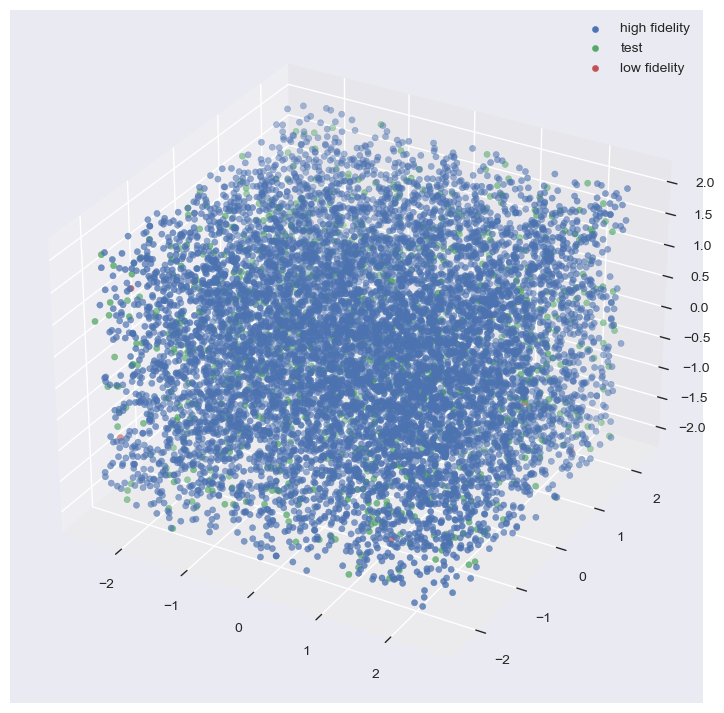

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_hifi[:, 0],X_hifi[:, 1],X_hifi[:, 2],label = 'high fidelity')
ax.scatter(X_test[:, 0],X_test[:, 1],X_test[:, 2],label = 'test')
ax.scatter(X_lofi[:, 0],X_lofi[:, 1],X_lofi[:, 2],label = 'low fidelity')
plt.legend()
plt.show()


## High Fidelity Model

Initialize a high fidelity neural network model. The model uses mean square error loss and Adam optimizer for training. The code defines the neural network model with one input layer, one hidden layer, and one output layer. The input size is determined by the number of features in the input data. The hidden layer has 128 neurons, and the output layer size is determined by the number of outputs in the training data.

In [8]:
from torch import nn # Neural Network Module
# Define hyperparameters
n_samples, n_features = X_hifi.shape
input_size = n_features
hidden_size = 128
output_size = Y_hifi.shape[1]
learning_rate = 1e-2
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

The code trains the model for a specified number of epochs on the training data. The data is fed to the model in batches. The model makes predictions on the training data and backpropagates the prediction error to update the model parameters. The loss is printed after every 10 epochs.

The code saves the state of the neural network to a file after training. The model is tested on the test data, and the average test loss is printed.

In [9]:
# Define a neural network model with input size, hidden size, and output size, then move it to the device (CPU or GPU)
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

''' Construct loss and optmizer '''
# Define a loss function for the neural network to minimize. Mean Square Error Loss is used in this case.
criterion = nn.MSELoss() # loss_fn = nn.CrossEntropyLoss()
# Define an optimizer to update the parameters of the neural network during training. Adam optimizer is used in this case.
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) 

''' In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
and backpropagates the prediction error to update the model’s parameters '''

# Set the number of epochs for training the neural network. In each epoch, the neural network is trained on all training samples in batches.
NUM_EPOCHS = 1000 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
for epoch in range(NUM_EPOCHS):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        ''' Compute prediction error '''
        # Forward pass the input data through the neural network to compute the predicted output.
        pred = nn_model(X)         
        # Compute the loss between the predicted output and the true output.
        loss = criterion(pred, y) 

        ''' Backpropagation '''
        # Clear the gradients from the previous iteration.
        optimizer.zero_grad()   
        # Compute the gradients for all the parameters in the neural network using backpropagation.
        loss.backward()          
        # Update the parameters of the neural network using the computed gradients.
        optimizer.step()         

    # Print the loss after every 10 epochs.   
    if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {NUM_EPOCHS}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")

''' SAVE THE MODEL'''
# Save the state of the neural network to a file.
cwd = os.getcwd()
model_file = "testcase_nn_model_state.pt"
torch.save(nn_model.state_dict(), os.path.join(cwd, model_file))

''' Test '''    
# Set the neural network to evaluation mode to disable the gradient calculation for test dataset.
nn_model.eval()
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, num_samples = 0, 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        # Forward pass the input data through the neural network to compute the predicted output.
        pred = nn_model(X)
        # Compute the loss between the predicted output and the true output.
        test_loss += criterion(pred, y).item()
        #num_samples += y.shape[0]
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
# Compute the average test loss.
test_loss /= num_batches
#correct /= size
#acc = 100.0 * correct / num_samples
# Print the test loss.
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

NeuralNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 10 / 88000, step [281/281] loss: 0.1689
Epoch 20 / 88000, step [281/281] loss: 0.2704
Epoch 30 / 88000, step [281/281] loss: 0.2025
Epoch 40 / 88000, step [281/281] loss: 0.1097
Epoch 50 / 88000, step [281/281] loss: 0.2053
Epoch 60 / 88000, step [281/281] loss: 0.1258
Epoch 70 / 88000, step [281/281] loss: 0.1854
Epoch 80 / 88000, step [281/281] loss: 0.0665
Epoch 90 / 88000, step [281/281] loss: 0.1570
Epoch 100 / 88000, step [281/281] loss: 0.2639
Epoch 110 / 88000, step [281/281] loss: 0.3380
Epoch 120 / 88000, step [281/281] loss: 0.1848
Epoch 130 / 88000, step [281/281] loss: 0.1390
Epoch 140 / 88000, step [281/281] loss: 0.1455
Epoch 150 / 88000, step [281/281] loss: 0.0852
Epoch 160 / 88000, step [281/281] loss: 0.1743
Epoch 170 / 88000, step [281/281] loss: 0.1163
Epoch

Import the state of a previously trained neural network model. The NeuralNet class, defined earlier, takes the same input size, hidden size, and output size as the saved model. The load_state_dict method is used to load the saved state of the neural network from a file. In this case, the file is located in the model_weights directory. Once the model is loaded, it is set to evaluation mode using the eval() method.

In [9]:
# Import the state of the neural network model saved
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
nn_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "model_weights/testcase_nn_model_state_PCA_88000_dualobj.pt")))
nn_model.eval()

NeuralNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

Visualizes the neural network prediction compared to the test data. First we load the saved state of the neural network model using load_state_dict() and set the model to evaluation mode using eval(). Then, using the torch.no_grad() context manager, the model predicts the output Y_pred for the test data X_test. Finally, we create a plot to compare the predicted output to the true output for each target variable in Y_test. The plot shows a scatter plot of the test data and the predicted data on the same axes for each feature of X_test.

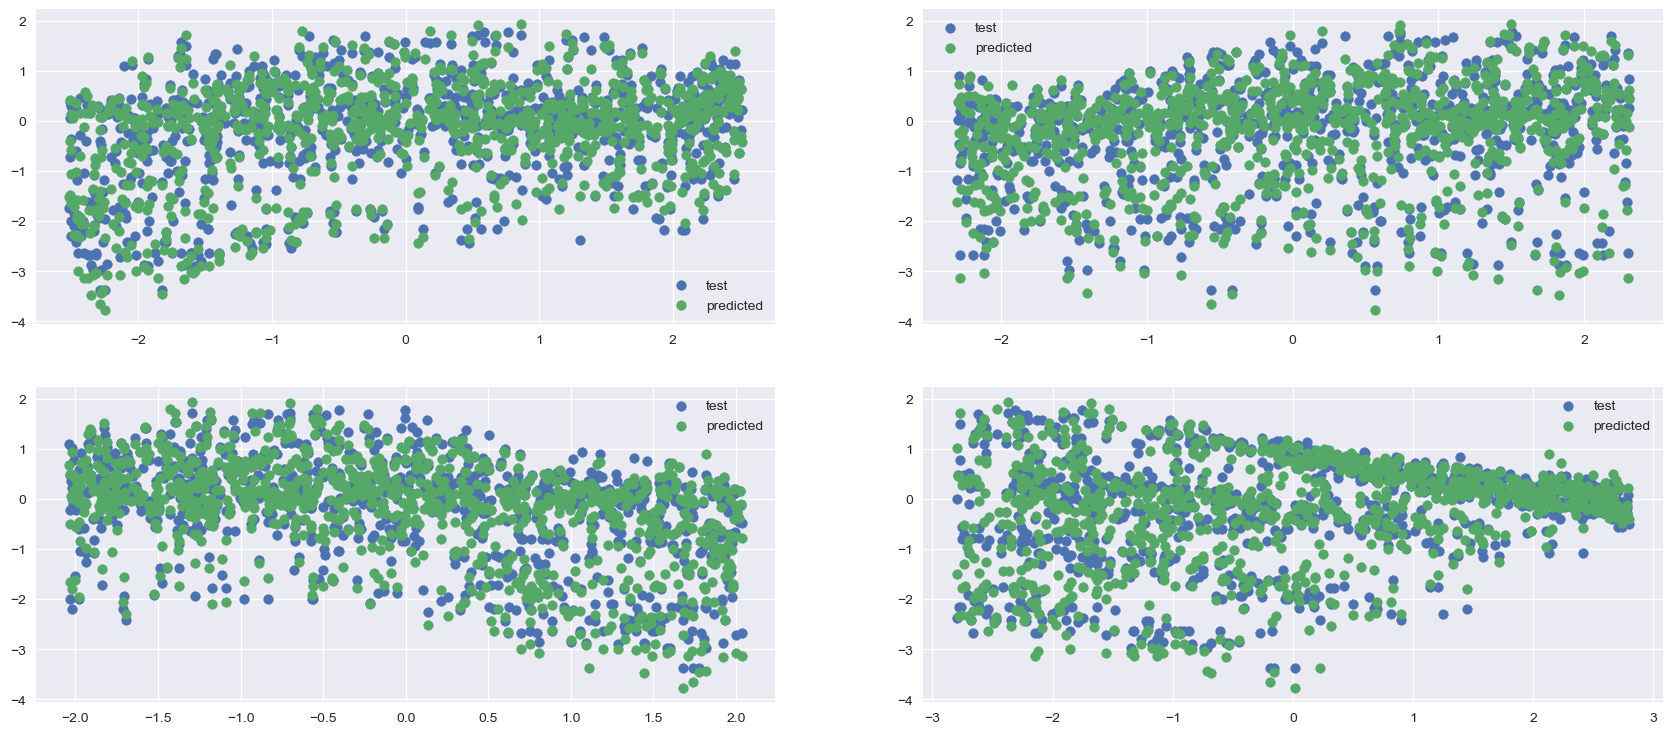

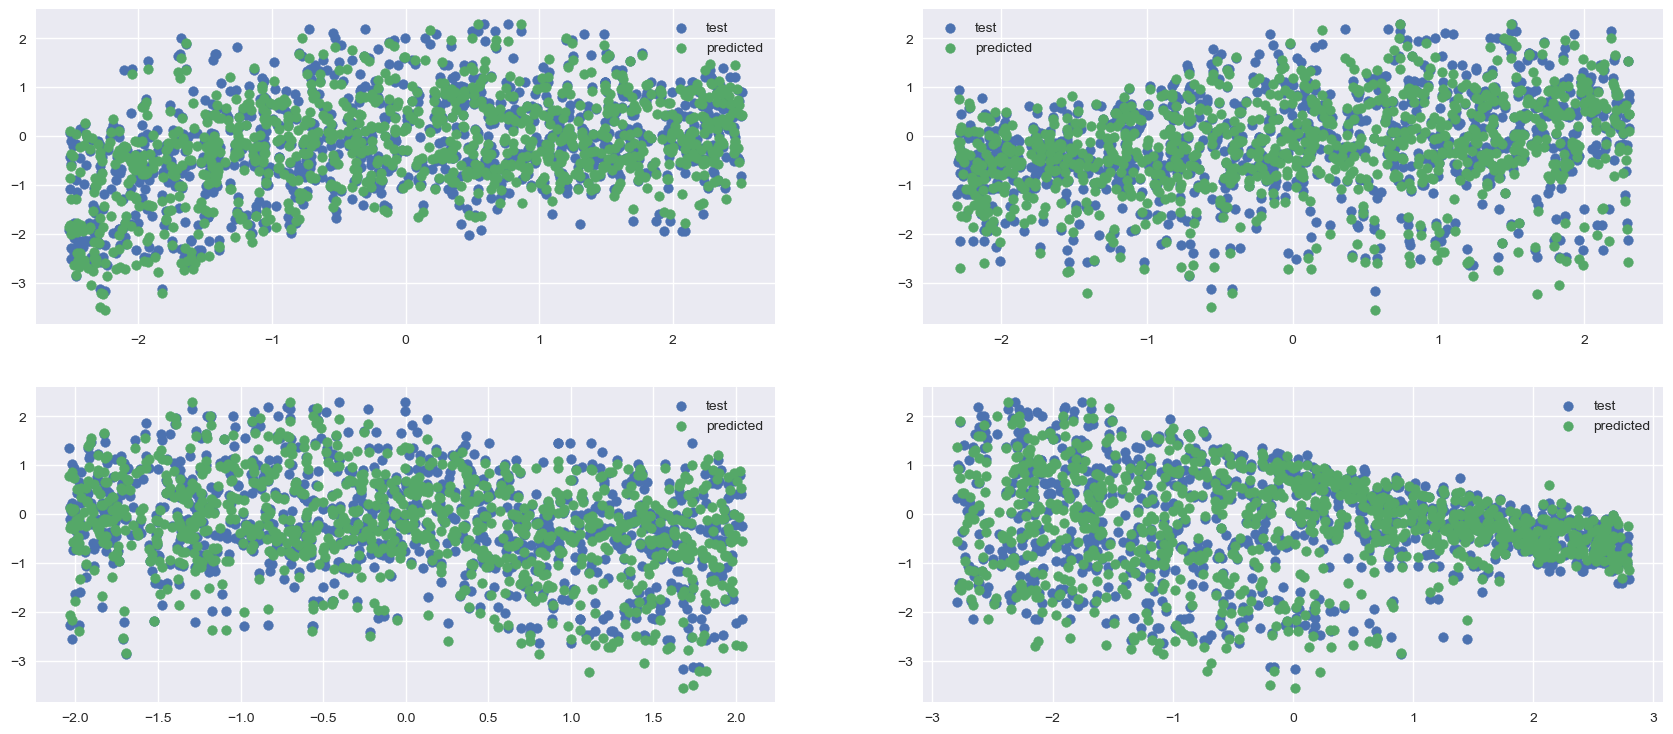

In [10]:
# Prediction vs the test data
with torch.no_grad():
    Y_pred = nn_model(X_test)

for i in range(Y_test.shape[-1]):
    fig = plt.figure(figsize=(21, 9))
    for alpha in range(X_test.shape[-1]):
        ax = fig.add_subplot(2, 2, alpha+1)
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,i].numpy(),label = 'test')
        ax.scatter(X_test[:,alpha].numpy(), Y_pred[:,i].numpy(),label = 'predicted')
        plt.legend()


## Surrogate Model
Initialize a surrogate model using Gaussian Processes (GP) to predict the output values given a set of input features. We use the botorch library to create a SingleTaskGP model for each output dimension in Y and then combine them into a ModelListGP. The likelihood of the GP is set to Gaussian with a specified noise level. We also define a function to initialize the GP model by taking input features X, output values Y, and noise level as inputs. The function returns the marginal log-likelihood and the initialized GP model. We also add the option to load a saved state dictionary of the GP model.

In [11]:
from botorch.models import SingleTaskGP, FixedNoiseGP, ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

# define a function to initialize the Gaussian Process model
def initialize_model(X, Y, noise, state_dict=None):
  # move X and Y to the device
  train_x, train_obj = X.to(device), Y.to(device)
  # create an empty list of models
  models = []
  # define a Gaussian likelihood with specified noise level
  likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=noise)#, learn_additional_noise=False)
  
  # loop over each output dimension in Y
  for i in range(train_obj.shape[-1]):
      train_y = train_obj[..., i : i + 1]
      # create a single task Gaussian Process for each output dimension
      models.append(
          SingleTaskGP(
              train_x, train_y
          )
      )
  # create a model list GP by passing all the created SingleTaskGP models
  model = ModelListGP(*models)
  # define the marginal log-likelihood as sum of marginal log-likelihoods of all the models
  mll = SumMarginalLogLikelihood(model.likelihood, model)

  #mll = ExactMarginalLogLikelihood(likelihood, single_model) # OTHER LIKELIHOOD ?
  ''' load state dict if it is passed '''
  if state_dict is not None:
    model.load_state_dict(state_dict)
  return mll, model

### Define a helper function that performs the essential BO step
We define a helper function for Bayesian Optimization (BO) by performing the essential BO step. The function uses the botorch library for optimizing the acquisition function. The function takes an acquisition function as an argument and returns a new candidate point that maximizes the acquisition function. The acquisition function is optimized using multiple restarts and raw samples, and the function is constrained to a set of bounds. Finally, the predicted optimal objective value is obtained by evaluating the neural network model at the candidate point. The constants NUM_POINTS, NUM_RESTARTS, RAW_SAMPLES, and NUM_INITIAL_POINTS are defined at the beginning of the code to control the optimization parameters.

In [12]:
from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed

NUM_POINTS = 1 if not SMOKE_TEST else 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32
NUM_INITIAL_POINTS = X_lofi.shape[0]

def opt_acq_and_get_next_obj(acqf):
  """Optimizes the acquisition function, and returns a new candidate."""
  with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf, 
        bounds=bounds,
        q=NUM_POINTS,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 10, "maxiter": 200},
    )
  ''' get a new obj '''
  with torch.no_grad():
    predicted_optimal_obj = nn_model(candidates)
  return candidates, predicted_optimal_obj

### Perform a few steps of MFBO
We performs a few steps of Multi-Fidelity Bayesian optimization. The implementation involves several packages such as botorch.acquisition, botorch.fit, botorch.sampling, etc. The initialize_model function initializes the Gaussian Process (GP) model for each acquisition function to optimize. The function also applies the noise model to the input and output, i.e., X_lofi and Y_lofi.

The objective of this implementation is to iterate until it converges on accuracy test with test data (NN). It includes different acquisition functions such as Upper Confidence Bound (UCB), Probability of Improvement (PI), Expected Improvement (EI), q-Expected Improvement (qEI), q-Noisy Expected Improvement (qNEI), and q-Knowledge Gradient (qKG).

The implementation fits the models, defines the qEI and qNEI acquisition modules using a QMC sampler, and uses the best observed noisy values as an approximation. The implementation also uses fit_gpytorch_mll function to optimize the negative log-marginal likelihood (NLL) of the GP model.

For each acquisition function, the implementation applies its corresponding acquisition module to maximize the acquisition function. It uses optimize_acqf function to optimize the acquisition function. The implementation sets the bounds and the number of iterations to perform the optimization. Finally, the acquisition function with the maximum value is used as the next candidate for the high-fidelity input.

In [48]:
from botorch.acquisition import (UpperConfidenceBound,
                                 ProbabilityOfImprovement,
                                 NoisyExpectedImprovement,
                                 ExpectedImprovement,
                                 qKnowledgeGradient, # too much computational expensive wrt the provided performance/accuracy
                                 PosteriorMean)
from botorch.acquisition.monte_carlo import (qExpectedImprovement, 
                                             qNoisyExpectedImprovement)
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.fit import fit_gpytorch_mll
from botorch.sampling import SobolQMCNormalSampler
import warnings
#warnings.filterwarnings("ignore", category=NumericalWarning)

N_ITER = 32 if not SMOKE_TEST else 1 # hp: not enough NUM_EPOCHS or training the nn model could lead to NumericalWarning in high N_ITER
NUM_FANTASIES = 128 if not SMOKE_TEST else 4
MC_SAMPLES = 256 if not SMOKE_TEST else 32

X_lofi = X_lofi[0:NUM_INITIAL_POINTS]
Y_lofi = Y_lofi[0:NUM_INITIAL_POINTS]
''' ITERATE UNTIL CONVERGE ON ACCURACY TEST WITH TEST DATA (NN)'''

X_lofi_UCB,  Y_lofi_UCB  = X_lofi, Y_lofi
X_lofi_PI,   Y_lofi_PI   = X_lofi, Y_lofi
X_lofi_EI,   Y_lofi_EI   = X_lofi, Y_lofi
X_lofi_qEI,  Y_lofi_qEI  = X_lofi, Y_lofi
X_lofi_qNEI, Y_lofi_qNEI = X_lofi, Y_lofi
'''X_lofi_qKG,  qKG_Y_lofi  = X_lofi, Y_lofi
X_lofi_qKGp, qKGp_Y_lofi = X_lofi, Y_lofi'''

mll,      gp_model      = initialize_model(X_lofi,      Y_lofi,      noise)
mll_UCB,  gp_model_UCB  = initialize_model(X_lofi_UCB,  Y_lofi_UCB,  noise)
mll_PI,   gp_model_PI   = initialize_model(X_lofi_PI,   Y_lofi_PI,   noise)
mll_EI,   gp_model_EI   = initialize_model(X_lofi_EI,   Y_lofi_EI,   noise)
mll_qEI,  gp_model_qEI  = initialize_model(X_lofi_qEI,  Y_lofi_qEI,  noise)
mll_qNEI, gp_model_qNEI = initialize_model(X_lofi_qNEI, Y_lofi_qNEI, noise)
'''mll_qKG,  gp_model_qKG  = initialize_model(X_lofi,  Y_lofi,  noise)
mll_qKGp, gp_model_qKGp = initialize_model(X_lofi, Y_lofi, noise)'''

for iter in range(N_ITER):

     ''' fit the models '''
     fit_gpytorch_mll(mll)
     fit_gpytorch_mll(mll_UCB)
     fit_gpytorch_mll(mll_PI)
     fit_gpytorch_mll(mll_EI)
     fit_gpytorch_mll(mll_qEI)
     fit_gpytorch_mll(mll_qNEI)

     ''' define the qEI and qNEI acquisition modules using a QMC sampler '''
     sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
     
     pt = ScalarizedPosteriorTransform(weights=torch.tensor([0.5, 0.5]))

     ''' for best_f, we use the best observed noisy values as an approximation '''
     UCB  = UpperConfidenceBound(
          model = gp_model_UCB, 
          beta=0.3,
          posterior_transform=pt,
     )
     PI  = ProbabilityOfImprovement( 
          model = gp_model_PI, 
          best_f = Y_lofi_PI.max(),
          posterior_transform=pt,
          )
     EI  = ExpectedImprovement( 
          model = gp_model_EI, 
          best_f = Y_lofi_EI.max() ,
          posterior_transform=pt,
     )
     qEI  = qExpectedImprovement( 
          model = gp_model_qEI, 
          best_f = Y_lofi_qEI.max(), 
          sampler=sampler,
          posterior_transform=pt,
     )
     qNEI  = qNoisyExpectedImprovement(
          model = gp_model_qNEI, 
          X_baseline = X_lofi_qNEI, 
          sampler=sampler,
          posterior_transform=pt,
     )
     '''qKG  = qKnowledgeGradient(
          model = gp_model_qKG, 
          num_fantasies=NUM_FANTASIES
     )
     qKG_proper  = qKnowledgeGradient(
          model = gp_model_qKGp, 
          num_fantasies=NUM_FANTASIES
     )
     argmax_pmean, max_pmean = optimize_acqf(
      acq_function=PosteriorMean(single_model), 
      bounds=bounds,
      q=NUM_POINTS,
      num_restarts=10 if not SMOKE_TEST else 2,
      raw_samples=1024 if not SMOKE_TEST else 4,
     )
     acqf_name = qKnowledgeGradient(
      single_model,
      num_fantasies=NUM_FANTASIES,
      sampler=qKG.sampler,
      current_value=max_pmean,
    )'''
     ''' optimize and get new observation '''
     new_X_UCB,  predicted_optimal_obj_UCB  = opt_acq_and_get_next_obj(UCB)  
     new_X_PI,   predicted_optimal_obj_PI   = opt_acq_and_get_next_obj(PI)  
     new_X_EI,   predicted_optimal_obj_EI   = opt_acq_and_get_next_obj(EI)  
     new_X_qEI,  predicted_optimal_obj_qEI  = opt_acq_and_get_next_obj(qEI)  
     new_X_qNEI, predicted_optimal_obj_qNEI = opt_acq_and_get_next_obj(qNEI)  
     new_X = (bounds[1] - bounds[0]) * torch.rand(new_X_qNEI.shape) + bounds[0]
     with torch.no_grad(): predicted_obj = nn_model(new_X) + NOISE_LEVEL * torch.randn(1)

     print(f"Iter {iter+1}/{N_ITER}")# - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")

     ''' update training points '''
     X_lofi      = torch.cat([X_lofi,      new_X ])
     X_lofi_UCB  = torch.cat([X_lofi_UCB,  new_X_UCB ])
     X_lofi_PI   = torch.cat([X_lofi_PI,   new_X_PI ])
     X_lofi_EI   = torch.cat([X_lofi_EI,   new_X_EI ])
     X_lofi_qEI  = torch.cat([X_lofi_qEI,  new_X_qEI ])
     X_lofi_qNEI = torch.cat([X_lofi_qNEI, new_X_qNEI ])

     Y_lofi      = torch.cat([Y_lofi,      predicted_obj])
     Y_lofi_UCB  = torch.cat([Y_lofi_UCB,  predicted_optimal_obj_UCB])
     Y_lofi_PI   = torch.cat([Y_lofi_PI,   predicted_optimal_obj_PI])
     Y_lofi_EI   = torch.cat([Y_lofi_EI,   predicted_optimal_obj_EI])
     Y_lofi_qEI  = torch.cat([Y_lofi_qEI,  predicted_optimal_obj_qEI])
     Y_lofi_qNEI = torch.cat([Y_lofi_qNEI, predicted_optimal_obj_qNEI])

     noise  = torch.cat([noise, 1e-3*torch.ones(Y_lofi_qNEI.shape[0]) ])

     mll,      gp_model      = initialize_model(X_lofi,      Y_lofi,      noise, gp_model.state_dict())
     mll_UCB,  gp_model_UCB  = initialize_model(X_lofi_UCB,  Y_lofi_UCB,  noise, gp_model_UCB.state_dict())
     mll_PI,   gp_model_PI   = initialize_model(X_lofi_PI,   Y_lofi_PI,   noise, gp_model_PI.state_dict())
     mll_EI,   gp_model_EI   = initialize_model(X_lofi_EI,   Y_lofi_EI,   noise, gp_model_EI.state_dict())
     mll_qEI,  gp_model_qEI  = initialize_model(X_lofi_qEI,  Y_lofi_qEI,  noise, gp_model_qEI.state_dict())
     mll_qNEI, gp_model_qNEI = initialize_model(X_lofi_qNEI, Y_lofi_qNEI, noise, gp_model_qNEI.state_dict())
     '''mll_qKG,  gp_model_qKG  = initialize_model(qKG_X_lofi,  qKG_Y_lofi,  noise)
     mll_qKGp, gp_model_qKGp = initialize_model(qKGp_X_lofi, qKGp_Y_lofi, noise)'''

# NumericalWarning for which acqf ?

Iter 1/32
Iter 2/32
Iter 3/32
Iter 4/32
Iter 5/32
Iter 6/32
Iter 7/32
Iter 8/32
Iter 9/32
Iter 10/32
Iter 11/32
Iter 12/32
Iter 13/32
Iter 14/32
Iter 15/32
Iter 16/32
Iter 17/32
Iter 18/32
Iter 19/32
Iter 20/32
Iter 21/32
Iter 22/32
Iter 23/32
Iter 24/32
Iter 25/32
Iter 26/32
Iter 27/32
Iter 28/32
Iter 29/32
Iter 30/32
Iter 31/32
Iter 32/32


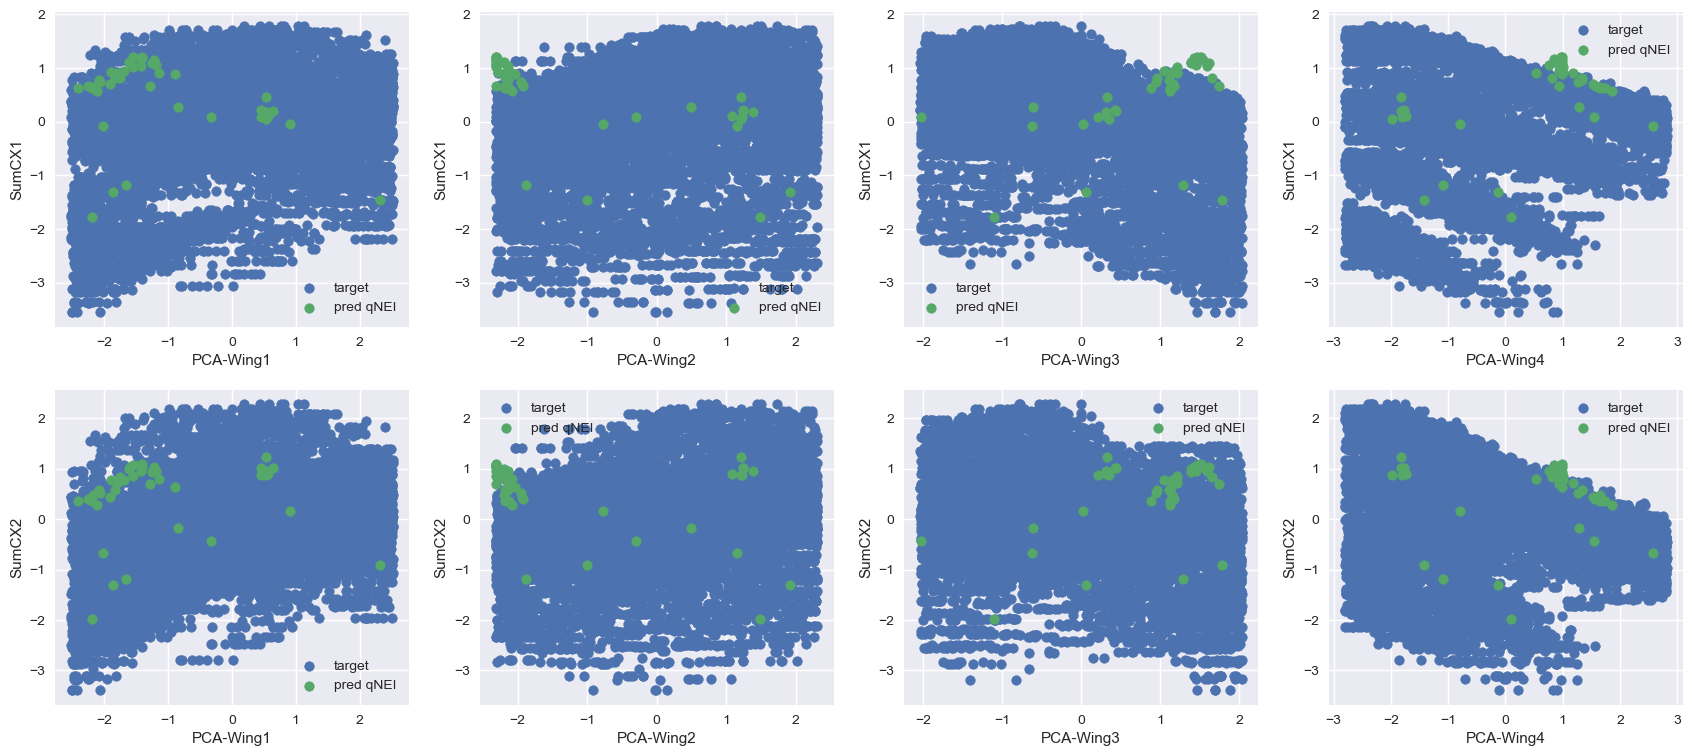

In [71]:
fig = plt.figure(figsize=(21, 9))
for i in range(Y_lofi.shape[-1]):
    for alpha in range(X_lofi.shape[-1]):
        ax = fig.add_subplot(2, 4, alpha+4*i+1)
        ax.scatter(X_hifi[:,alpha].numpy(), Y_hifi[:,i].numpy(),label = 'target')
        #ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi[:,i].numpy(),label = 'predicted')
        #ax.scatter(X_lofi_UCB[:,alpha].numpy(), Y_lofi_UCB[:,i].numpy(),label = 'pred UCB')
        #ax.scatter(X_lofi_PI[ :,alpha].numpy(), Y_lofi_PI[ :,i].numpy(),label = 'pred PI')
        #ax.scatter(X_lofi_EI[ :,alpha].numpy(), Y_lofi_EI[ :,i].numpy(),label = 'pred EI')
        #ax.scatter(X_lofi_qEI[:,alpha].numpy(), Y_lofi_qEI[:,i].numpy(),label = 'pred qEI')
        ax.scatter(X_lofi_qNEI[:,alpha].numpy(), Y_lofi_qNEI[:,i].numpy(),label = 'pred qNEI')
        plt.legend()
        plt.xlabel(f"PCA-Wing{alpha+1}")
        plt.ylabel(f"SumCX{i+1}")
plt.show() 

In [49]:
# Define the Kernel of Gaussian Process
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train, likelihood=gpytorch.likelihoods.GaussianLikelihood()):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [50]:
def gp_visualization(x_train,y_train,alpha=0,iter=1000,acqf='acqf'):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    train_multi_yvar = noise**2*torch.ones(x_train.unsqueeze(-1).shape[0],1, device=device)
    ''' Define the model '''
    #gp_model = FixedNoiseGP(x_train.unsqueeze(-1), y_train, train_multi_yvar)
    #gp_model = SingleTaskGP(x_train.unsqueeze(-1), y_train, likelihood = likelihood  )
    gp_model = ExactGPModel(x_train, y_train.squeeze(), likelihood)
    ''' Find optimal model hyperparameters '''
    gp_model.train()
    likelihood.train()
    ''' Use the adam optimizer '''  # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3)
    ''' "Loss" for GPs - the marginal log likelihood '''
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)
    training_iter = iter
    for i in range(training_iter):
        ''' Zero gradients from previous iteration '''
        optimizer.zero_grad()    
        ''' Output from model '''
        output = gp_model(x_train)
        ''' compute loss and backprop gradients '''
        loss = -mll(output, y_train.squeeze())
        loss.backward()
        if (i+1) % 100 == 0:
            print(f'Wing{alpha+1}: {acqf} - Iter {i + 1}/{training_iter}')# - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
    print('\n')
    return gp_model.eval(), likelihood.eval()

In [52]:
TRAIN_ITER = 1000 if not SMOKE_TEST else 4
likelihood_list,      gp_model_list      = [],[]
likelihood_UCB_list,  gp_model_UCB_list  = [],[]
likelihood_PI_list,   gp_model_PI_list   = [],[]
likelihood_EI_list,   gp_model_EI_list   = [],[]
likelihood_qEI_list,  gp_model_qEI_list  = [],[]
likelihood_qNEI_list, gp_model_qNEI_list = [],[]
for alpha in range(2):#X_lofi.shape[-1]):
    ''' Fit the model '''
    likelihood,      gp_model      = gp_visualization(X_lofi[NUM_INITIAL_POINTS:,alpha],     Y_lofi[NUM_INITIAL_POINTS:,0],     alpha,iter=TRAIN_ITER, acqf='rand')
    likelihood_UCB,  gp_model_UCB  = gp_visualization(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha], Y_lofi_UCB[NUM_INITIAL_POINTS:,0], alpha,iter=TRAIN_ITER, acqf='UCB')
    likelihood_PI,   gp_model_PI   = gp_visualization(X_lofi_PI[NUM_INITIAL_POINTS:,alpha],  Y_lofi_PI[NUM_INITIAL_POINTS:,0],  alpha,iter=TRAIN_ITER, acqf='PI')
    likelihood_EI,   gp_model_EI   = gp_visualization(X_lofi_EI[NUM_INITIAL_POINTS:,alpha],  Y_lofi_EI[NUM_INITIAL_POINTS:,0],  alpha,iter=TRAIN_ITER, acqf='EI')
    likelihood_qEI,  gp_model_qEI  = gp_visualization(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha], Y_lofi_qEI[NUM_INITIAL_POINTS:,0], alpha,iter=TRAIN_ITER, acqf='qEI')
    likelihood_qNEI, gp_model_qNEI = gp_visualization(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha],Y_lofi_qNEI[NUM_INITIAL_POINTS:,0],alpha,iter=TRAIN_ITER, acqf='qNEI')
    likelihood_list.append(likelihood),           gp_model_list.append(gp_model)
    likelihood_UCB_list.append(likelihood_UCB),   gp_model_UCB_list.append(gp_model_UCB)
    likelihood_PI_list.append(likelihood_PI),     gp_model_PI_list.append(gp_model_PI)
    likelihood_EI_list.append(likelihood_EI),     gp_model_EI_list.append(gp_model_EI)
    likelihood_qEI_list.append(likelihood_qEI),   gp_model_qEI_list.append(gp_model_qEI)
    likelihood_qNEI_list.append(likelihood_qNEI), gp_model_qNEI_list.append(gp_model_qNEI)

Wing1: rand - Iter 100/1000
Wing1: rand - Iter 200/1000
Wing1: rand - Iter 300/1000
Wing1: rand - Iter 400/1000
Wing1: rand - Iter 500/1000
Wing1: rand - Iter 600/1000
Wing1: rand - Iter 700/1000
Wing1: rand - Iter 800/1000
Wing1: rand - Iter 900/1000
Wing1: rand - Iter 1000/1000


Wing1: UCB - Iter 100/1000
Wing1: UCB - Iter 200/1000
Wing1: UCB - Iter 300/1000
Wing1: UCB - Iter 400/1000
Wing1: UCB - Iter 500/1000
Wing1: UCB - Iter 600/1000
Wing1: UCB - Iter 700/1000
Wing1: UCB - Iter 800/1000
Wing1: UCB - Iter 900/1000
Wing1: UCB - Iter 1000/1000


Wing1: PI - Iter 100/1000
Wing1: PI - Iter 200/1000
Wing1: PI - Iter 300/1000
Wing1: PI - Iter 400/1000
Wing1: PI - Iter 500/1000
Wing1: PI - Iter 600/1000
Wing1: PI - Iter 700/1000
Wing1: PI - Iter 800/1000
Wing1: PI - Iter 900/1000
Wing1: PI - Iter 1000/1000


Wing1: EI - Iter 100/1000
Wing1: EI - Iter 200/1000
Wing1: EI - Iter 300/1000
Wing1: EI - Iter 400/1000
Wing1: EI - Iter 500/1000
Wing1: EI - Iter 600/1000
Wing1: EI - Iter 700/1000

In [ ]:
#del gp_model, gp_model_UCB, gp_model_PI, gp_model_EI, gp_model_qEI, gp_model_qNEI

for alpha in range(2):#X_lofi.shape[-1]):
    ''' Fit the model '''
 
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_UCB = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_PI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_EI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_qEI = gpytorch.likelihoods.GaussianLikelihood()
    likelihood_qNEI = gpytorch.likelihoods.GaussianLikelihood()

    train_multi_yvar = noise**2*torch.ones(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1).shape[0],1, device=device)

    ''' Define the model '''
    #gp_model      = FixedNoiseGP(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),      Y_lofi[NUM_INITIAL_POINTS:],      train_multi_yvar)
    #gp_model_UCB  = FixedNoiseGP(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_UCB[NUM_INITIAL_POINTS:],  train_multi_yvar)
    #gp_model_PI   = FixedNoiseGP(X_lofi_PI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_PI[NUM_INITIAL_POINTS:],   train_multi_yvar)
    #gp_model_EI   = FixedNoiseGP(X_lofi_EI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_EI[NUM_INITIAL_POINTS:],   train_multi_yvar)
    #gp_model_qEI  = FixedNoiseGP(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_qEI[NUM_INITIAL_POINTS:],  train_multi_yvar)
    #gp_model_qNEI = FixedNoiseGP(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1), Y_lofi_qNEI[NUM_INITIAL_POINTS:], train_multi_yvar)

    #gp_model       = SingleTaskGP(X_lofi[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),      Y_lofi[NUM_INITIAL_POINTS:],      likelihood = likelihood  )
    #gp_model_UCB   = SingleTaskGP(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_UCB[NUM_INITIAL_POINTS:],  likelihood = likelihood_UCB  )
    #gp_model_PI    = SingleTaskGP(X_lofi_PI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_PI[NUM_INITIAL_POINTS:],   likelihood = likelihood_PI  )
    #gp_model_EI    = SingleTaskGP(X_lofi_EI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),   Y_lofi_EI[NUM_INITIAL_POINTS:],   likelihood = likelihood_EI  )
    #gp_model_qEI   = SingleTaskGP(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1),  Y_lofi_qEI[NUM_INITIAL_POINTS:],  likelihood = likelihood_qEI  )
    #gp_model_qNEI  = SingleTaskGP(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha].unsqueeze(-1), Y_lofi_qNEI[NUM_INITIAL_POINTS:], likelihood = likelihood_qNEI  )

    gp_model      = ExactGPModel(X_lofi[NUM_INITIAL_POINTS:,alpha] ,      Y_lofi[NUM_INITIAL_POINTS:,0].squeeze(),      likelihood)
    gp_model_UCB  = ExactGPModel(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha] ,  Y_lofi_UCB[NUM_INITIAL_POINTS:,0].squeeze(),  likelihood_UCB)
    gp_model_PI   = ExactGPModel(X_lofi_PI[NUM_INITIAL_POINTS:,alpha] ,   Y_lofi_PI[NUM_INITIAL_POINTS:,0].squeeze(),   likelihood_PI)
    gp_model_EI   = ExactGPModel(X_lofi_EI[NUM_INITIAL_POINTS:,alpha] ,   Y_lofi_EI[NUM_INITIAL_POINTS:,0].squeeze(),   likelihood_EI)
    gp_model_qEI  = ExactGPModel(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha] ,  Y_lofi_qEI[NUM_INITIAL_POINTS:,0].squeeze(),  likelihood_qEI)
    gp_model_qNEI = ExactGPModel(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha] , Y_lofi_qNEI[NUM_INITIAL_POINTS:,0].squeeze(), likelihood_qNEI)
    ''' Find optimal model hyperparameters '''
    gp_model.train()
    gp_model_UCB.train()
    gp_model_PI.train()
    gp_model_EI.train()
    gp_model_qEI.train()
    gp_model_qNEI.train()
    likelihood.train()
    likelihood_UCB.train()
    likelihood_PI.train()
    likelihood_EI.train()
    likelihood_qEI.train()
    likelihood_qNEI.train()
    ''' Use the adam optimizer '''  # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) 
    optimizer_UCB = torch.optim.Adam(gp_model_UCB.parameters(),lr=1e-3)
    optimizer_PI = torch.optim.Adam(gp_model_PI.parameters(),lr=1e-3)
    optimizer_EI = torch.optim.Adam(gp_model_EI.parameters(),lr=1e-3)
    optimizer_qEI = torch.optim.Adam(gp_model_qEI.parameters(),lr=1e-3)
    optimizer_qNEI = torch.optim.Adam(gp_model_qNEI.parameters(),lr=1e-3)
    ''' "Loss" for GPs - the marginal log likelihood '''
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) 
    mll_UCB = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_UCB, gp_model_UCB)
    mll_PI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_PI, gp_model_PI)
    mll_EI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_EI, gp_model_EI)
    mll_qEI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_qEI, gp_model_qEI)
    mll_qNEI = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_qNEI, gp_model_qNEI)
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

    training_iter  = 1000 if not SMOKE_TEST else 4
    for i in range(training_iter):
        ''' Zero gradients from previous iteration '''
        optimizer.zero_grad()    
        optimizer_UCB.zero_grad()
        optimizer_PI.zero_grad()
        optimizer_EI.zero_grad()
        optimizer_qEI.zero_grad()
        optimizer_qNEI.zero_grad()
        ''' Output from model '''
        output = gp_model(X_lofi[NUM_INITIAL_POINTS:,alpha])        
        output_UCB = gp_model_UCB(X_lofi_UCB[NUM_INITIAL_POINTS:,alpha])
        output_PI = gp_model_PI(X_lofi_PI[NUM_INITIAL_POINTS:,alpha])
        output_EI = gp_model_EI(X_lofi_EI[NUM_INITIAL_POINTS:,alpha])
        output_qEI = gp_model_qEI(X_lofi_qEI[NUM_INITIAL_POINTS:,alpha])
        output_qNEI = gp_model_qNEI(X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha])
        ''' compute loss and backprop gradients '''
        loss = -mll(output, Y_lofi[NUM_INITIAL_POINTS:,0].squeeze())
        loss_UCB = -mll_UCB(output_UCB, Y_lofi_UCB[NUM_INITIAL_POINTS:,0].squeeze())
        loss_PI = -mll_PI(output_PI, Y_lofi_PI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_EI = -mll_EI(output_EI, Y_lofi_EI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_qEI = -mll_qEI(output_qEI, Y_lofi_qEI[NUM_INITIAL_POINTS:,0].squeeze())
        loss_qNEI = -mll_qNEI(output_qNEI, Y_lofi_qNEI[NUM_INITIAL_POINTS:,0].squeeze())     
        loss.backward()
        loss_UCB.backward()
        loss_PI.backward()
        loss_EI.backward()
        loss_qEI.backward()
        loss_qNEI.backward()
        if (i+1) % 100 == 0:
            print(f'Wing{alpha+1} - Iter {i + 1}/{training_iter}')# - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
        optimizer_UCB.step()
        optimizer_PI.step()
        optimizer_EI.step()
        optimizer_qEI.step()
        optimizer_qNEI.step()
    print('\n')
    
    gp_model.eval()
    gp_model_UCB.eval()
    gp_model_PI.eval()
    gp_model_EI.eval()
    gp_model_qEI.eval()
    gp_model_qNEI.eval()
    likelihood.eval()
    likelihood_UCB.eval()
    likelihood_PI.eval()
    likelihood_EI.eval()
    likelihood_qEI.eval()
    likelihood_qNEI.eval() # si può rimuovere? --> con una funzione apposita?


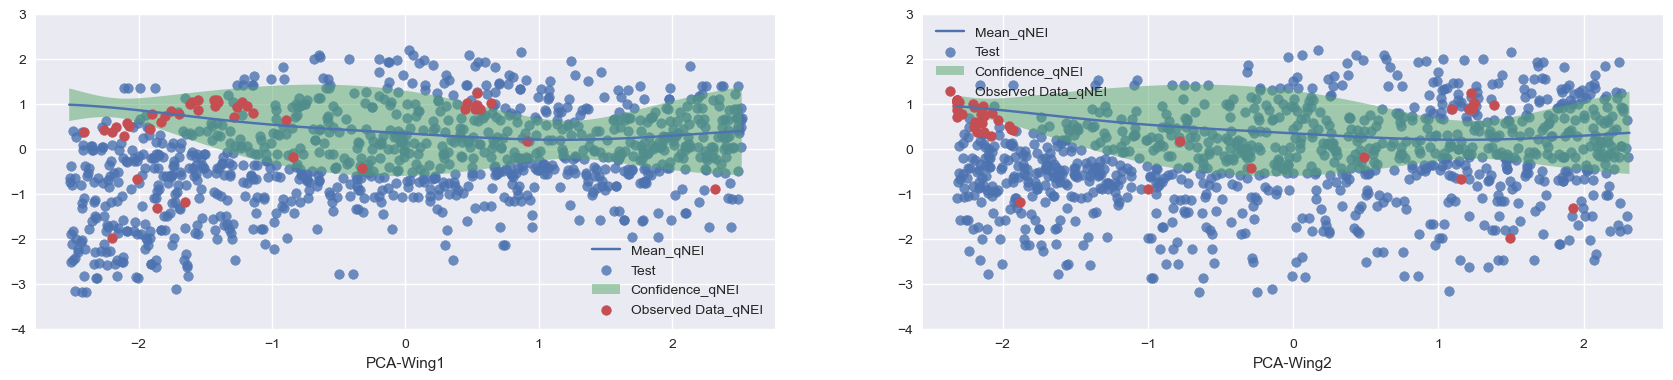

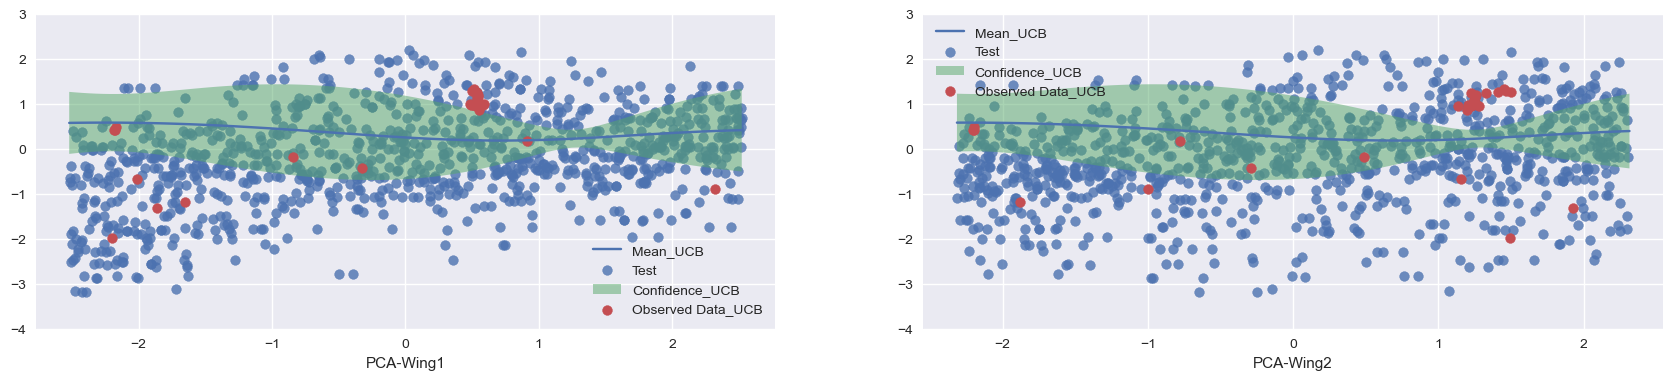

<Figure size 2100x900 with 0 Axes>

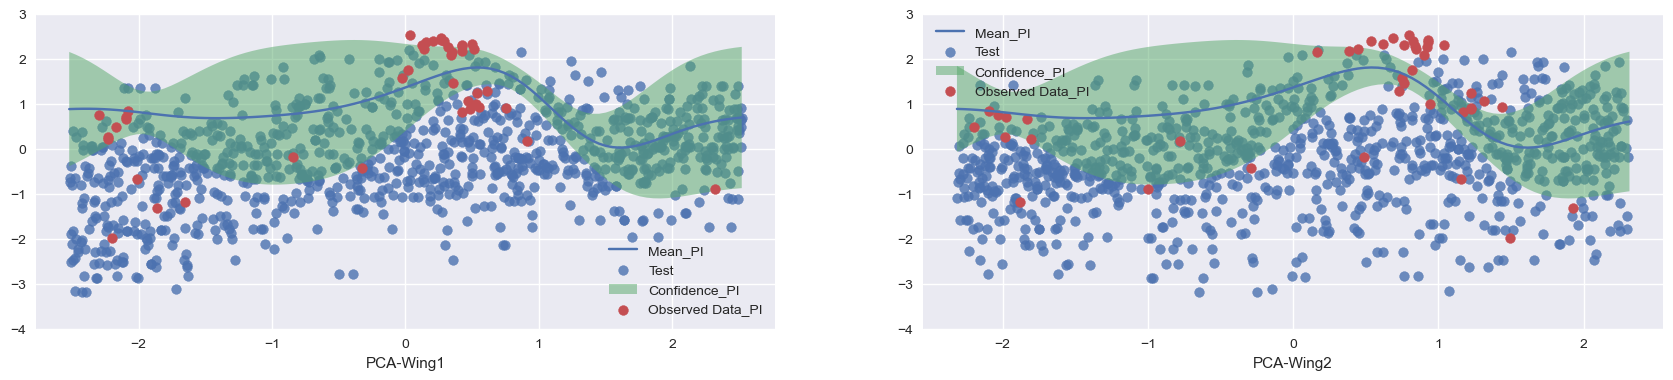

<Figure size 2100x900 with 0 Axes>

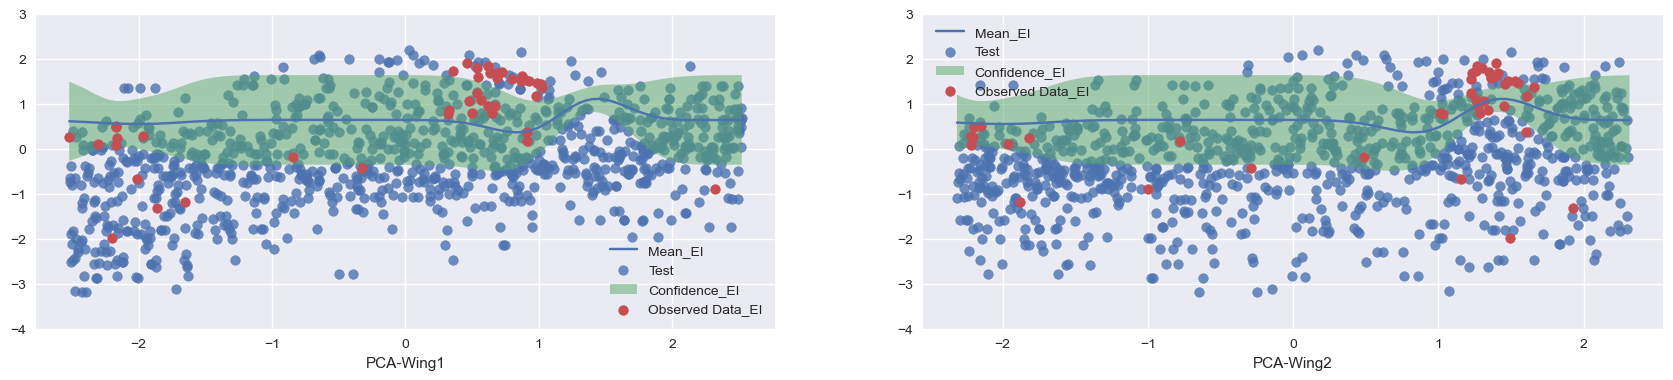

<Figure size 2100x900 with 0 Axes>

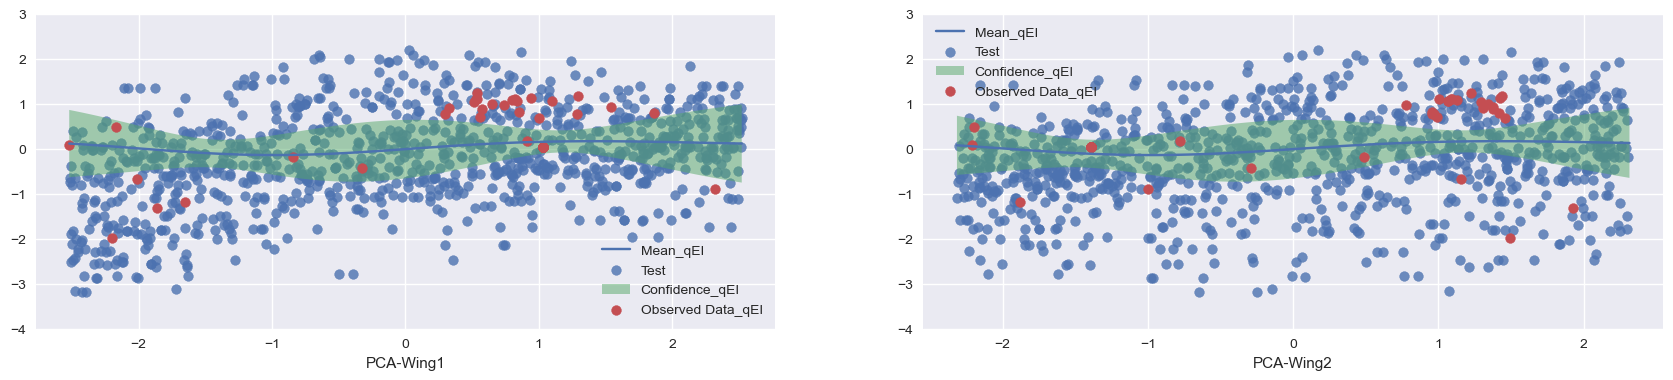

<Figure size 2100x900 with 0 Axes>

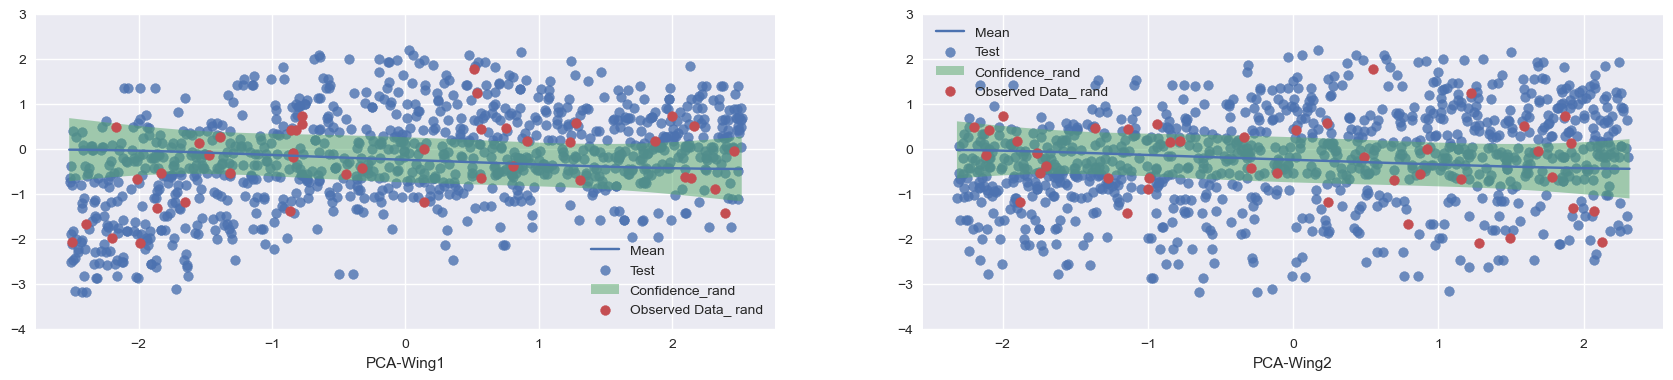

<Figure size 2100x900 with 0 Axes>

In [56]:
fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred_qNEI = likelihood_qNEI((test_x ))  
        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,1].numpy(), alpha=0.8, label = 'Test')
         
        # Get upper and lower confidence bounds # Plot predictive means as blue line
        lower, upper = observed_pred_qNEI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_qNEI.mean.numpy(), label = 'Mean_qNEI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_qNEI')  
        ax.scatter(X_lofi_qNEI[:,alpha].numpy(), Y_lofi_qNEI[:,1].numpy(), s=50,label = 'Observed Data_qNEI')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()
fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred_UCB = (likelihood_UCB(test_x )) 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,-1].numpy(), alpha=0.8, label = 'Test')

        lower, upper = observed_pred_UCB.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_UCB.mean.numpy(), label = 'Mean_UCB')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_UCB')  
        ax.scatter(X_lofi_UCB[:,alpha].numpy(), Y_lofi_UCB[:,-1].numpy(), s=50,label = 'Observed Data_UCB')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()

fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred_PI = (likelihood_PI(test_x )) 
  
        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,-1].numpy(), alpha=0.8, label = 'Test')
         
        lower, upper = observed_pred_PI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_PI.mean.numpy(), label = 'Mean_PI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_PI')  
        ax.scatter(X_lofi_PI[:,alpha].numpy(), Y_lofi_PI[:,-1].numpy(), s=50,label = 'Observed Data_PI')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()

fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred_EI = (likelihood_EI(test_x )) 

        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,-1].numpy(), alpha=0.8, label = 'Test')

        lower, upper = observed_pred_EI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_EI.mean.numpy(), label = 'Mean_EI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_EI')  
        ax.scatter(X_lofi_EI[:,alpha].numpy(), Y_lofi_EI[:,-1].numpy(), s=50,label = 'Observed Data_EI')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()

fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred_qEI = (likelihood_qEI(test_x )) 

        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,-1].numpy(), alpha=0.8, label = 'Test')

        lower, upper = observed_pred_qEI.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred_qEI.mean.numpy(), label = 'Mean_qEI')    
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_qEI')  
        ax.scatter(X_lofi_qEI[:,alpha].numpy(), Y_lofi_qEI[:,-1].numpy(), s=50,label = 'Observed Data_qEI')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()

fig = plt.figure(figsize=(21, 9))

for alpha in range(2):#X_lofi.shape[1]):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        # Make predictions by feeding model through likelihood
        observed_pred = (likelihood(test_x ))    

        # Initialize plot 
        ax = fig.add_subplot(2, 2, alpha+1)      
        ax.scatter(X_test[:,alpha].numpy(), Y_test[:,-1].numpy(), alpha=0.8, label = 'Test')
         
        # Get upper and lower confidence bounds # Plot predictive means as blue line
        lower, upper = observed_pred.confidence_region() 
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')    

        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence_rand') 
        ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi[:,-1].numpy(), s=50,label = 'Observed Data_ rand')

        ax.set_ylim([-4,3])
        plt.xlabel(f"PCA-Wing{alpha+1}")
        ax.legend()

plt.show()
# ADD NON-PCA DATA (ORIGINAL DATA) PLOT

## Plotly
We define some helper functions for creating and updating a Plotly graph in the interactive dashboard. The update_layout_of_graph function updates the layout of the graph with the specified title, x-axis and y-axis labels, legend orientation and position, and axis line properties. The uncertainty_area_scatter function creates a scatter plot with an area filled between the upper and lower bounds. The line_scatter function creates a line plot from the specified x and y values. The test_scatter function creates a scatter plot of test data points. The dot_scatter function creates a scatter plot of observed data points. All functions return a Plotly scatter plot object.

In [38]:
import plotly.graph_objs as go
from plotly_visualization import *

In [79]:
def update_layout_of_graph(fig: go.Figure,title: str = 'Plot')->go.Figure:
    fig.update_layout(
        width=800,
        height=600,
        autosize=False,
        plot_bgcolor='rgba(0,0,0,0)',
        title=title,
        
    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                      xaxis_title = 'input values',
                      yaxis_title = 'output values',
                      legend=dict(orientation="h",
                                  yanchor="bottom",
                                  y=1.02,
                                  xanchor="right",
                                  x=1),
                      title={
                          'x': 0.5,
                          'xanchor': 'center'
                      })
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
    return fig

def uncertainty_area_scatter(
        visible: bool = True,
        x_lines: np.array = np.array([]),
        y_upper: np.array = np.array([]),
        y_lower: np.array = np.array([]),
        name: str = "mean plus/minus standard deviation",
        legend_group: str = 'acqf',
        showlegend: bool = False,
) -> go.Scatter:

    return go.Scatter(
        visible=visible,
        x=np.concatenate((x_lines, x_lines[::-1])),  # x, then x reversed
        # upper, then lower reversed
        y=np.concatenate((y_upper, y_lower[::-1])),
        fill='toself',
        fillcolor='rgba(189,195,199,0.5)',
        line=dict(color='rgba(200,200,200,0)'),
        hoverinfo="skip",
        name= name,
        legendgroup = legend_group,
        showlegend=showlegend,
    )

def line_scatter(
    visible: bool = True,
    x_lines: np.array = np.array([]),
    y_lines: np.array = np.array([]),
    name_line: str = 'Predicted function',
    legend_group: str = 'acqf',
    color: str = 'blue',
    showlegend: bool = True,
) -> go.Scatter:
    # Adding the lines
    return go.Scatter(
        visible=visible,
        line=dict(color=color, width=2),
        x=x_lines,
        y=y_lines,
        name=name_line,
        legendgroup = legend_group,
        showlegend= showlegend
    )

def test_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Test',
    showlegend: bool = True
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        name=name_dots,
        marker=dict(color='green', size=7),
        showlegend=showlegend
    )

def dot_scatter(
    visible: bool = True,
    x_dots: np.array = np.array([]),
    y_dots: np.array = np.array([]),
    name_dots: str = 'Obs',
    legend_group: str = 'acqf',
    color: str = 'red',
    showlegend: bool = False
) -> go.Scatter:
    # Adding the dots
    return go.Scatter(
        x=x_dots,
        visible=visible,
        y=y_dots,
        mode="markers",
        legendgroup = legend_group,
        name=name_dots,
        marker=dict(color=color, size=7),
        showlegend=showlegend
    )


In [57]:
def plot_GPR(data_x, data_y, model, x, legend_group, color=None, visible=True) -> list:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed = model(x)
        lower, upper = observed.confidence_region()
        data = []
        
        data.append(
            uncertainty_area_scatter(
                x_lines=x.numpy(),
                y_lower=lower.numpy(),
                y_upper=upper.numpy(),
                name=f"uncertainty",
                legend_group = legend_group,
                visible=visible))
        data.append(line_scatter(x_lines=x.numpy(), y_lines=observed.mean.numpy(), visible=visible, name_line =legend_group, color=color, legend_group = legend_group))
        data.append(dot_scatter(x_dots=data_x.numpy(), y_dots=data_y.numpy(), visible=visible, color=color, legend_group = legend_group))
        
    return data

In [60]:
for alpha in range(2):
    test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
    plot      = plot_GPR(data_x=X_lofi[NUM_INITIAL_POINTS:,alpha],      
                         data_y=Y_lofi[NUM_INITIAL_POINTS:,-1],      
                         x=test_x, model=likelihood_list[alpha],     legend_group="rand"
                         )
    plot_UCB  = plot_GPR(data_x=X_lofi_UCB[NUM_INITIAL_POINTS:,alpha],  
                         data_y=Y_lofi_UCB[NUM_INITIAL_POINTS:,0],  
                         x=test_x, model=likelihood_UCB_list[alpha], legend_group="UCB",  color = 'coral'
                         )
    plot_PI   = plot_GPR(data_x=X_lofi_PI[NUM_INITIAL_POINTS:,alpha],   
                         data_y=Y_lofi_PI[NUM_INITIAL_POINTS:,0],   
                         x=test_x, model=likelihood_PI_list[alpha],  legend_group="PI",   color = 'cornflowerblue'
                         )
    plot_EI   = plot_GPR(data_x=X_lofi_EI[NUM_INITIAL_POINTS:,alpha],   
                         data_y=Y_lofi_EI[NUM_INITIAL_POINTS:,0],   
                         x=test_x, model=likelihood_EI_list[alpha],  legend_group="EI",   color = 'crimson'
                         )
    plot_qEI  = plot_GPR(data_x=X_lofi_qEI[NUM_INITIAL_POINTS:,alpha],  
                         data_y=Y_lofi_qEI[NUM_INITIAL_POINTS:,0],  
                         x=test_x, model=likelihood_qEI_list[alpha], legend_group="qEI",  color = 'darkblue'
                         )
    plot_qNEI = plot_GPR(data_x=X_lofi_qNEI[NUM_INITIAL_POINTS:,alpha], 
                         data_y=Y_lofi_qNEI[NUM_INITIAL_POINTS:,0], 
                         x=test_x, model=likelihood_qNEI_list[alpha],legend_group="qNEI", color = 'darkgoldenrod'
                         )
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(
        x=X_test[:,alpha],
        y=Y_test[:,0],
        legendgroup="Test",  
        name="Test",
        mode="markers",
        marker=dict(color="burlywood", size=7)
    ))
    fig4.add_traces(data=plot )
    fig4.add_traces(data=plot_UCB )
    fig4.add_traces(data=plot_PI )
    fig4.add_traces(data=plot_EI )
    fig4.add_traces(data=plot_qEI )
    fig4.add_traces(data=plot_qNEI)
    fig4.update_layout(
            width=1500,
            height=800,
            autosize=False,
            plot_bgcolor='rgba(0,0,0,0)',
            title='WingPCA'+str(alpha+1)+' - GPR on Opt Points vs Test Points')
    fig4 = update_layout_of_graph(fig=fig4,
                              title='GPR on Opt Points vs Test Points')
    fig4.show()